In [1]:
pip install --quiet git+https://github.com/amazon-science/chronos-forecasting.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import yfinance as yf
from chronos import ChronosPipeline
import warnings
from transformers import logging

logging.set_verbosity_error()
warnings.filterwarnings("ignore", category=UserWarning, module="huggingface_hub.utils._token")

In [3]:
# Definir las métricas
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def mape(y_true, y_pred):
    return 100 * np.mean(np.abs((y_true - y_pred) / y_true))

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

In [4]:
# Cargar el modelo preentrenado
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",
    device_map="cuda",
    torch_dtype=torch.bfloat16,
)

# Descargar datos de los 8 tickers
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2000-01-01', interval='1mo')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/806M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

[*********************100%***********************]  8 of 8 completed


Generando predicción para AAPL
Tiempo de predicción: 0.55 segundos
Métricas para AAPL:
SMAPE: 23.17%
MAPE: 20.63%
MSE: 2272.9939
MAE: 45.8298
RMSE: 47.6759



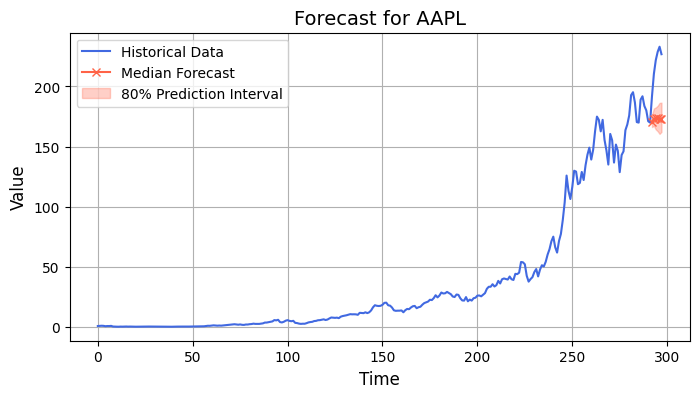

Generando predicción para AMZN
Tiempo de predicción: 0.49 segundos
Métricas para AMZN:
SMAPE: 6.35%
MAPE: 6.12%
MSE: 156.5570
MAE: 11.4214
RMSE: 12.5123



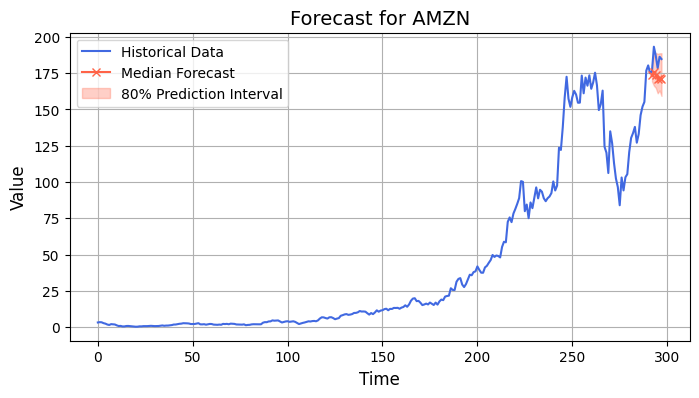

Generando predicción para BTC-USD
Tiempo de predicción: 0.24 segundos
Métricas para BTC-USD:
SMAPE: 17.69%
MAPE: 16.16%
MSE: 110956940.3860
MAE: 10186.0605
RMSE: 10533.6100



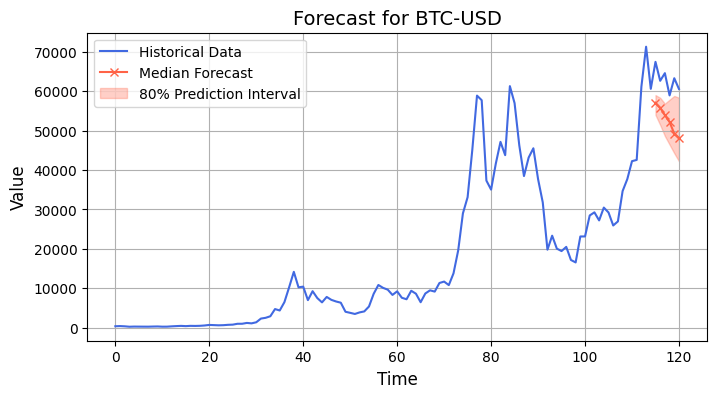

Generando predicción para GOOGL
Tiempo de predicción: 0.25 segundos
Métricas para GOOGL:
SMAPE: 4.23%
MAPE: 4.09%
MSE: 82.7896
MAE: 7.1428
RMSE: 9.0989



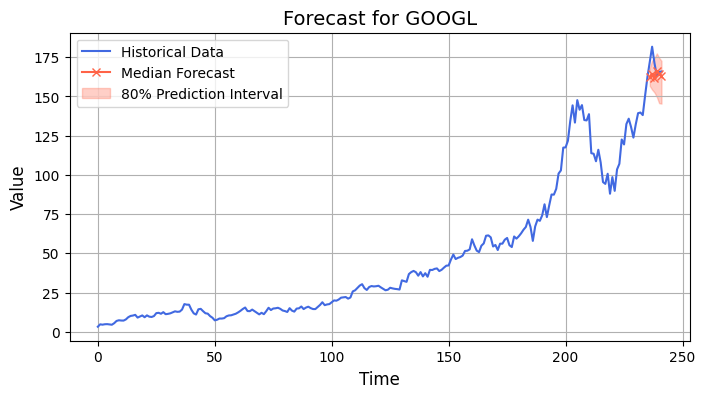

Generando predicción para IBM
Tiempo de predicción: 0.26 segundos
Métricas para IBM:
SMAPE: 16.41%
MAPE: 14.79%
MSE: 1304.7677
MAE: 30.5883
RMSE: 36.1216



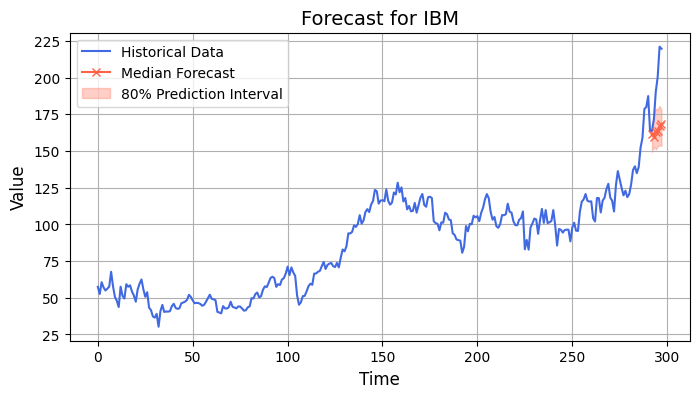

Generando predicción para META
Tiempo de predicción: 0.25 segundos
Métricas para META:
SMAPE: 27.18%
MAPE: 23.54%
MSE: 18552.1479
MAE: 125.4301
RMSE: 136.2063



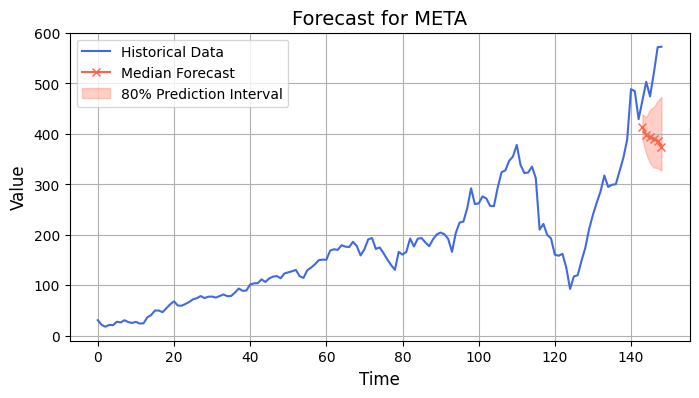

Generando predicción para MSFT
Tiempo de predicción: 0.39 segundos
Métricas para MSFT:
SMAPE: 11.40%
MAPE: 10.75%
MSE: 2256.4940
MAE: 45.7945
RMSE: 47.5026



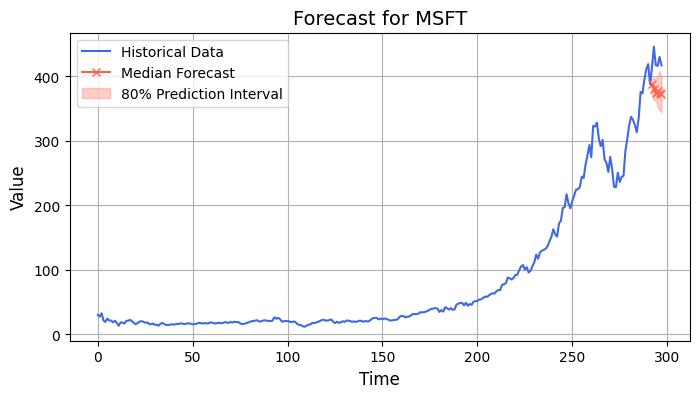

Generando predicción para NVDA
Tiempo de predicción: 0.33 segundos
Métricas para NVDA:
SMAPE: 36.00%
MAPE: 30.46%
MSE: 1326.4783
MAE: 36.1555
RMSE: 36.4208



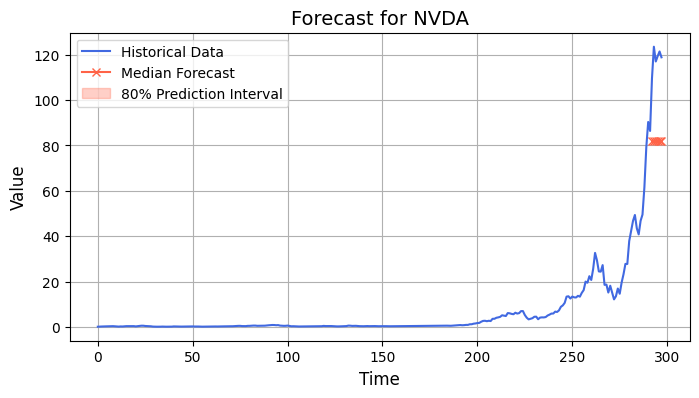

In [6]:
import time

# Obtener los tickers únicos
unique_ids = Y_df['unique_id'].unique()

# Definir la longitud de la predicción
prediction_length = 6

# Iterar sobre cada serie temporal
for ticker in unique_ids:

    predict_start = time.time()
    print(f"Generando predicción para {ticker}")

    # Filtrar los datos por ticker
    df_ticker = Y_df[Y_df['unique_id'] == ticker].reset_index(drop=True)

    # Separar los datos en entrenamiento y prueba
    train_size = len(df_ticker) - prediction_length
    Y_df_real = df_ticker.iloc[:train_size].copy()
    Y_df_test = df_ticker.iloc[train_size:].copy()

    # Asegurarse de que el contexto esté en el formato adecuado
    context = torch.tensor(Y_df_real['y'].to_numpy()).float()

    # Realizar la predicción
    forecast = pipeline.predict(context, prediction_length)  # shape [num_series, num_samples, prediction_length]

    predict_end = time.time()

    # Calcular el tiempo de predicción
    predict_time = predict_end - predict_start
    print(f"Tiempo de predicción: {predict_time:.2f} segundos")

    # Visualizar la predicción
    forecast_index = range(train_size, len(df_ticker))
    low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

    # Calcular las métricas
    y_true = Y_df_test['y'].to_numpy()
    y_pred = median

    smape_value = smape(y_true, y_pred)
    mape_value = mape(y_true, y_pred)
    mse_value = mse(y_true, y_pred)
    mae_value = mae(y_true, y_pred)
    rmse_value = rmse(y_true, y_pred)

    # Imprimir las métricas
    print(f'Métricas para {ticker}:')
    print(f'SMAPE: {smape_value:.2f}%')
    print(f'MAPE: {mape_value:.2f}%')
    print(f'MSE: {mse_value:.4f}')
    print(f'MAE: {mae_value:.4f}')
    print(f'RMSE: {rmse_value:.4f}\n')

    plt.figure(figsize=(8, 4))
    plt.plot(df_ticker['y'], color="royalblue", label="Historical Data")
    plt.plot(forecast_index, median, color="tomato", label="Median Forecast", marker='x')
    plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% Prediction Interval")
    plt.title(f'Forecast for {ticker}', fontsize=14)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid()
    plt.show()

